In [83]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import MyCode.utils as utils
import graphviz


In [84]:
pd.set_option('max_columns', None)
FILE_NAME = "relab_Lawsuit"

# src: https://www.kaggle.com/hjmjerry/gender-discrimination
df = pandas.read_csv("dataset_perso/Lawsuit.csv")
del df['ID']
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Sal94,Sal95
0,1,1,0,0,7.4,9,3,77836,84612
1,1,1,0,0,6.7,10,2,69994,78497
2,1,1,0,0,8.1,6,1,62872,67756
3,1,1,1,1,5.1,27,3,155196,173220
4,1,1,0,0,7.0,10,3,89268,96099
...,...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,297174,323699
257,6,0,1,1,2.6,9,3,308081,339664
258,6,0,1,1,2.8,8,1,211269,241577
259,6,0,1,1,2.4,2,1,210801,233905


In [85]:
salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Salary_mean
0,1,1,0,0,7.4,9,3,0.0
1,1,1,0,0,6.7,10,2,0.0
2,1,1,0,0,8.1,6,1,0.0
3,1,1,1,1,5.1,27,3,1.0
4,1,1,0,0,7.0,10,3,0.0
...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,1.0
257,6,0,1,1,2.6,9,3,1.0
258,6,0,1,1,2.8,8,1,1.0
259,6,0,1,1,2.4,2,1,1.0


In [86]:
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)
df


,Gender,Clin,Cert,Salary_mean,Rank_1,Rank_2,Rank_3,Dept_1,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6
0,1,0,0,0.0,0,0,1,1,0,0,0,0,0
1,1,0,0,0.0,0,1,0,1,0,0,0,0,0
2,1,0,0,0.0,1,0,0,1,0,0,0,0,0
3,1,1,1,1.0,0,0,1,1,0,0,0,0,0
4,1,0,0,0.0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,0,1,1,1.0,0,1,0,0,0,0,0,0,1
257,0,1,1,1.0,0,0,1,0,0,0,0,0,1
258,0,1,1,1.0,1,0,0,0,0,0,0,0,1
259,0,1,1,1.0,1,0,0,0,0,0,0,0,1


In [87]:
X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['Gender']
utils.discrimination(y, sensitive)

-0.31205112598904444

In [88]:
for i in range(0,len(df)):
    if df.at[i, "Gender"] == 1:
        df.at[i, "Gender"] = 0
    else:
        df.at[i, "Gender"] = 1
utils.discrimination(y, sensitive)

0.31205112598904444

In [89]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

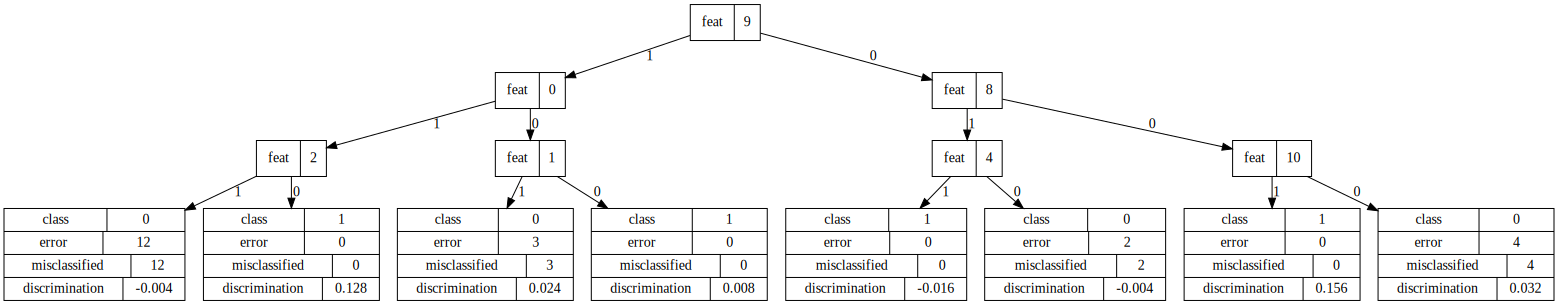

In [90]:
#clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.error(list(tids), 10, y_train, sensitive_train), min_sup=2,time_limit=600)
clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.misclassified(list(tids), y_train), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
utils.tree_upgrade(clf.tree_, y_train, sensitive_train)

dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)

In [91]:
import ast

y_pred_train = clf.predict(X_train)
discrimation_train = round(utils.discrimination(y_pred_train, sensitive_train), 4)
print(f"score: {clf.error_}")
print(f"acc: {round(accuracy_score(y_train, y_pred_train), 4)}")
print("Discrimination of classifier on train", discrimation_train)
print(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive', s=list(), bool=False))
print(utils.sum_elem_tree(clf.tree_, 'misclassified', s=list(), bool=False))

score: 21.0
acc: 0.8995
Discrimination of classifier on train 0.277
0.3256190476190477
21


In [92]:
from pprint import pprint

pprint(clf.tree_)

{'feat': 9,
 'left': {'feat': 0,
          'left': {'feat': 2,
                   'left': {'discrimination_additive': -0.0035238095238095193,
                            'error': 12.0,
                            'misclassified': 12,
                            'proba': [0.5714285714285714, 0.42857142857142855],
                            'transactions': [129,
                                             131,
                                             132,
                                             133,
                                             136,
                                             138,
                                             140,
                                             143,
                                             150,
                                             153,
                                             155,
                                             156,
                                             158,
                                    

In [93]:
result2 = pd.DataFrame(X_train, columns = X.columns)
result2["Class"] = y_train
result2["Sensitive"] = sensitive_train
result2["Pred"] = y_pred_train

In [94]:
result2

,Clin,Cert,Rank_1,Rank_2,Rank_3,Dept_1,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6,Class,Sensitive,Pred
0,0,0,0,0,1,1,0,0,0,0,0,0.0,0,0
1,0,0,1,0,0,1,0,0,0,0,0,0.0,0,0
2,1,1,0,0,1,1,0,0,0,0,0,1.0,0,0
3,0,0,0,0,1,1,0,0,0,0,0,0.0,0,0
4,0,1,0,0,1,1,0,0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,1,1,0,1,0,0,0,0,0,0,1,1.0,1,1
205,1,1,0,0,1,0,0,0,0,0,1,1.0,1,1
206,1,1,1,0,0,0,0,0,0,0,1,1.0,1,1
207,1,1,1,0,0,0,0,0,0,0,1,1.0,1,1


In [95]:
def compute_disc_t(dataset):
    length = len(dataset)
    w2 = len(dataset[(dataset['Sensitive'] == 0) & (dataset['Class'] == 0) & (dataset['Pred'] == 1)])/length
    x2 = len(dataset[(dataset['Sensitive'] == 0) & (dataset['Class'] == 1) & (dataset['Pred'] == 1)])/length
    u2 = len(dataset[(dataset['Sensitive'] == 1) & (dataset['Class'] == 0) & (dataset['Pred'] == 1)])/length
    v2 = len(dataset[(dataset['Sensitive'] == 1) & (dataset['Class'] == 1) & (dataset['Pred'] == 1)])/length

    b       = len(dataset[(dataset['Sensitive'] == 1)  & (dataset['Class'] == 0)]) + len(dataset[(dataset['Sensitive'] == 1)  & (dataset['Class'] == 1)])/length
    b_not   = len(dataset[(dataset['Sensitive'] == 0)  & (dataset['Class'] == 0)]) + len(dataset[(dataset['Sensitive'] == 0)  & (dataset['Class'] == 1)])/length

    """
    w1 = len(dataset[(dataset['Sensitive'] == 0) & (dataset['Class'] == 0) & (dataset['Pred'] == 0)])/lenght
    x1 = len(dataset[(dataset['Sensitive'] == 0) & (dataset['Class'] == 1) & (dataset['Pred'] == 0)])/lenght
    u1 = len(dataset[(dataset['Sensitive'] == 1) & (dataset['Class'] == 0) & (dataset['Pred'] == 0)])/lenght
    v1 = len(dataset[(dataset['Sensitive'] == 1) & (dataset['Class'] == 1) & (dataset['Pred'] == 0)])/lenght
    print(w1+w2+x1+x2+u1+u2+v1+v2)
    """

    return ((w2+x2)/b_not) - ((u2+v2)/b)
compute_disc_t(result2)

0.0033293050858906204

In [96]:
utils.discrimination(y_train, sensitive_train)

0.32561904761904764

In [97]:
class Leaf:
    def __init__(self, path, u, v, w, x):
        self.path = path
        self.acc=None
        self.disc=None
        self.ratio=None
        self.u = u
        self.v = v
        self.w = w
        self.x = x

    def accuracy(self, n_one, n_zero):
        n = self.u + self.w
        p = self.v + self.x
        if p >= n :
            self.acc = n - p
            self.disc = (self.u+self.v)/n_one - (self.w+self.x)/n_zero
        else:
            self.acc = p - n
            self.disc = -(self.u+self.v)/n_one + (self.w+self.x)/n_zero

        self.ratio = self.disc/self.acc

    def __str__(self):
        return f"Path: {self.path} \naccuracy: {self.acc} \ndisc: {self.disc} \nratio: {self.ratio} \ncontigency: \n{[self.u, self.v]}\n{[self.w, self.x]}"
    def __repr__(self):
        return f"{self.path}"

In [98]:
import copy

def relab1(tree, y, sensitive, n_zero, n_one, leafs, lenght, leaftuple= tuple()):
    if 'feat' in tree:
        tmp= leaftuple + ((tree['feat'], 'left'),)
        relab1(tree['left'], y, sensitive, n_zero, n_one, leafs, lenght, tmp)
        tmp= leaftuple + ((tree['feat'], 'right'),)
        relab1(tree['right'], y, sensitive, n_zero, n_one, leafs, lenght, tmp)
    else:
        tree = copy.deepcopy(tree)
        tree["u"] = 0
        tree["v"] = 0
        tree["w"] = 0
        tree["x"] = 0
        for id in tree["transactions"]:
            if sensitive[id] == 1 and tree["value"] == 0:
                tree["u"] += 1
            if sensitive[id] == 1 and tree["value"] == 1:
                tree["v"] += 1
            if sensitive[id] == 0 and tree["value"] == 0:
                tree["w"] += 1
            if sensitive[id] == 0 and tree["value"] == 1:
                tree["x"] += 1
                """"""
        n = (tree["u"]+tree["w"])
        p = (tree["v"]+tree["x"])
        if n<=p :
            tree["acc"] = n - p
            tree["disc"] = (tree["u"]+tree["v"])/n_one - (tree["w"]+tree["x"])/n_zero
        else:
            tree["acc"] = p - n
            tree["disc"] = -(tree["u"]+tree["v"])/n_one + (tree["w"]+tree["x"])/n_zero

        leaf = Leaf(leaftuple, tree["u"]/lenght, tree["v"]/lenght, tree["w"]/lenght, tree["x"]/lenght)
        leaf.accuracy(n_one, n_zero)
        leafs.append(leaf)
cnt = np.unique(sensitive, return_counts=True)[1]


In [99]:
leafs = list()
relab1(clf.tree_, y_train, sensitive_train, cnt[0], cnt[1], leafs, len(y_train))
#print(utils.sum_elem_tree(clf.tree_, "disc",  s=list(), bool=False))
pprint(clf.tree_)

{'feat': 9,
 'left': {'feat': 0,
          'left': {'feat': 2,
                   'left': {'discrimination_additive': -0.0035238095238095193,
                            'error': 12.0,
                            'misclassified': 12,
                            'proba': [0.5714285714285714, 0.42857142857142855],
                            'transactions': [129,
                                             131,
                                             132,
                                             133,
                                             136,
                                             138,
                                             140,
                                             143,
                                             150,
                                             153,
                                             155,
                                             156,
                                             158,
                                    

In [100]:
for leaf in leafs:
    print(leaf)
    print()

Path: ((9, 'left'), (0, 'left'), (2, 'left')) 
accuracy: -0.1339712918660287 
disc: -0.00027578213502549607 
ratio: 0.002058516650726024 
contigency: 
[0.07177033492822966, 0.0]
[0.06220095693779904, 0.0]

Path: ((9, 'left'), (0, 'left'), (2, 'right')) 
accuracy: -0.12440191387559808 
disc: -0.0004985628460017415 
ratio: 0.004007678262090922 
contigency: 
[0.0, 0.019138755980861243]
[0.0, 0.10526315789473684]

Path: ((9, 'left'), (0, 'right'), (1, 'left')) 
accuracy: -0.0430622009569378 
disc: 4.9798041277043103e-05 
ratio: -0.0011564211807668899 
contigency: 
[0.014354066985645933, 0.0]
[0.028708133971291867, 0.0]

Path: ((9, 'left'), (0, 'right'), (1, 'right')) 
accuracy: -0.004784688995215311 
disc: -3.086896125945362e-05 
ratio: 0.0064516129032258064 
contigency: 
[0.0, 0.0]
[0.0, 0.004784688995215311]

Path: ((9, 'right'), (8, 'left'), (4, 'left')) 
accuracy: -0.014354066985645932 
disc: 5.940818959366546e-05 
ratio: -0.004138770541692027 
contigency: 
[0.0, 0.009569377990430622]


In [101]:
l = Leaf(None, 1/20, 1/20, 1/20, 0)
l.accuracy(1/2,1/2)
print(l)

Path: None 
accuracy: -0.05 
disc: -0.1 
ratio: 2.0 
contigency: 
[0.05, 0.05]
[0.05, 0]


In [102]:
disc_t = compute_disc_t(result2)

# rem disc(𝐿) := disc 𝑇 + ∑ Δdisc 𝑙 ≤ 𝜖
def rem_disc(L, e):
    s = 0
    for leaf in L:
        if leaf.disc < e:
            s += leaf.disc
    return disc_t+s

def relab(leafs, e):
    # ℐ := { 𝑙 ∈ ℒ ∣ Δdisc 𝑙 < 0 }
    I = list()
    for leaf in leafs:
        if leaf.disc < 0:
            I.append(leaf)
    # 𝐿 := {}
    L = set()
    print(rem_disc(L, e))
    # while rem disc(𝐿) > 𝜖 do
    while rem_disc(L, e) > e and I:
        # best l := arg max 𝑙∈ℐ∖𝐿 (disc 𝑙 /acc 𝑙 )
        best_l = I[0]
        for leaf in I:
            if leaf.ratio > best_l.ratio:
                best_l = leaf
        # 𝐿 := 𝐿 ∪ {𝑙}
        L.add(best_l)
        I.remove(best_l)
        print(rem_disc(L, e))

    return L

leafs_relab = relab(leafs, 0)
print()
for l in leafs_relab:
    print(l)
    print()

0.0033293050858906204
0.003298436124631167
0.0027998732786294256
0.002192104201756975
0.0019425315621404492
0.0016667494271149531
0.001131493287540654

Path: ((9, 'right'), (8, 'left'), (4, 'right')) 
accuracy: -0.09090909090909091 
disc: -0.00024957263961652596 
ratio: 0.0027452990357817856 
contigency: 
[0.05263157894736842, 0.0]
[0.03827751196172249, 0.0]

Path: ((9, 'right'), (8, 'right'), (10, 'right')) 
accuracy: -0.4354066985645933 
disc: -0.0005352561395742994 
ratio: 0.0012293245403409733 
contigency: 
[0.21052631578947367, 0.0]
[0.22488038277511962, 0.0]

Path: ((9, 'left'), (0, 'left'), (2, 'right')) 
accuracy: -0.12440191387559808 
disc: -0.0004985628460017415 
ratio: 0.004007678262090922 
contigency: 
[0.0, 0.019138755980861243]
[0.0, 0.10526315789473684]

Path: ((9, 'left'), (0, 'right'), (1, 'right')) 
accuracy: -0.004784688995215311 
disc: -3.086896125945362e-05 
ratio: 0.0064516129032258064 
contigency: 
[0.0, 0.0]
[0.0, 0.004784688995215311]

Path: ((9, 'left'), (0, '

In [103]:
clf.tree_['left']['left']['right']['value']=1
clf.tree_['right']['left']['left']['value']=0
clf.tree_['right']['right']['left']['value']=0

In [104]:
utils.tree_upgrade(clf.tree_, y_train, sensitive_train)

pprint(clf.tree_)

{'feat': 9,
 'left': {'feat': 0,
          'left': {'feat': 2,
                   'left': {'discrimination_additive': -0.0035238095238095193,
                            'error': 12.0,
                            'misclassified': 12,
                            'proba': [0.5714285714285714, 0.42857142857142855],
                            'transactions': [129,
                                             131,
                                             132,
                                             133,
                                             136,
                                             138,
                                             140,
                                             143,
                                             150,
                                             153,
                                             155,
                                             156,
                                             158,
                                    

In [105]:
y_pred_train = clf.predict(X_train)
discrimation_train = round(utils.discrimination(y_pred_train, sensitive_train), 4)
print(f"score: {clf.error_}")
print(f"acc: {round(accuracy_score(y_train, y_pred_train), 4)}")
print("Discrimination of classifier on train", discrimation_train)
print(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive', s=list(), bool=False))
print(utils.sum_elem_tree(clf.tree_, 'misclassified', s=list(), bool=False))

score: 21.0
acc: 0.7321
Discrimination of classifier on train 0.1364
0.3256190476190477
21
